In [2]:
import sys
import os
_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.insert(0, _path)
print('done adding path')
    
import astropy.coordinates as coord
import numpy as np
from gala.units import UnitSystem
from yellowcard.model import TimingArgumentModel 
from yellowcard.coordinates import fiducial_m31_c
from yellowcard.coordinates import fiducial_m31_c,LocalGroupHalocentric
import astropy.units as u
from scipy.optimize import minimize
import emcee
import arviz as az
from schwimmbad import MultiPool 
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

done adding path


In [3]:
# plt.rcParams.update({'font.size':22,'text.usetex':False})

In [25]:
#####################
# testing from adrian - with zero transverse velocity!
galcen_frame = coord.Galactocentric(galcen_distance = 8.29*u.kpc, 
                                    galcen_v_sun = [11.1, 12.24 + 239.3, 7.25] * u.km/u.s, z_sun = 0*u.pc)

m31_c = coord.SkyCoord(ra = fiducial_m31_c.ra,
                       dec = fiducial_m31_c.dec,
                       distance = 770*u.kpc)
m31_lgh = m31_c.transform_to(galcen_frame).transform_to(LocalGroupHalocentric())
pos = m31_lgh.data.represent_as(coord.SphericalRepresentation)
v_rad_only = coord.SphericalDifferential(0*u.mas/u.yr, 0*u.mas/u.yr, -110*u.km/u.s)
lgh = LocalGroupHalocentric(pos.with_differentials(v_rad_only))
v_rad_only_icrs = lgh.transform_to(galcen_frame).transform_to(coord.ICRS())

# distance to m31
D, D_err = (770, 40)* u.kpc # in kpc
D_term = (D_err/D)**2

model = TimingArgumentModel(distance = D,
                            pm = u.Quantity([v_rad_only_icrs.pm_ra_cosdec, v_rad_only_icrs.pm_dec]),
                            radial_velocity = v_rad_only_icrs.radial_velocity,
                            tperi = 13.75*u.Gyr,
                            distance_err = D_err,
                            pm_err = u.Quantity([1*u.microarcsecond/u.yr, 1*u.microarcsecond/u.yr]),
                            radial_velocity_err = 1 * u.km / u.s,
                            tperi_err = .11 * u.Gyr,
                            galcen_frame = galcen_frame)

In [26]:
# # # VDM 2012
# galcen_frame = coord.Galactocentric(galcen_distance = 8.29*u.kpc, 
#                                     galcen_v_sun = [11.1, 12.24 + 239.3, 7.25] * u.km/u.s, z_sun = 0*u.pc)

# # vw and vn + error
# vW, vW_err = (-125.2, 30.8)* u.km/u.s # in kpc
# vN, vN_err = (-73.8, 28.4)* u.km/u.s # in kpc
# vW_term = (vW_err/vW)**2
# vN_term = (vN_err/vN)**2

# # distance to m31
# D, D_err = (770, 40)* u.kpc # in kpc
# D_term = (D_err/D)**2

# # calculate equiv pms 
# mu_alpha_star, mu_delta = ( ((- vW / D)*u.rad).to(u.microarcsecond/u.yr), ((vN / D)*u.rad).to(u.microarcsecond/u.yr))

# # equiv pm errors
# mu_alpha_star_err = np.sqrt( mu_alpha_star**2 * (vW_term - D_term) ) 
# mu_delta_err = np.sqrt( mu_delta**2 * (vN_term - D_term) ) 

# # print(mu_alpha_star, mu_delta, mu_alpha_star_err, mu_delta_err)

# model = TimingArgumentModel(distance = D,
#                             pm = u.Quantity([mu_alpha_star, mu_delta]),
#                             radial_velocity = -301*u.km/u.s,
#                             tperi = 13.75*u.Gyr,
#                             distance_err = D_err,
#                             pm_err = u.Quantity([mu_alpha_star_err, mu_delta_err]),
#                             radial_velocity_err = 1 * u.km / u.s,
#                             tperi_err = .11 * u.Gyr,
#                             galcen_frame = galcen_frame)

In [27]:
# # made up 4 testing
# model = TimingArgumentModel(distance = fiducial_m31_c.distance,
#                             pm = u.Quantity([fiducial_m31_c.pm_ra_cosdec, fiducial_m31_c.pm_dec]),
#                             radial_velocity = fiducial_m31_c.radial_velocity,
#                             tperi = 13.7*u.Gyr,
#                             distance_err = 10*u.kpc,
#                             pm_err = u.Quantity([10*u.microarcsecond/u.yr, 10*u.microarcsecond/u.yr]),
#                             radial_velocity_err = 10 * u.km / u.s,
#                             tperi_err = .25 * u.Gyr,
#                             )

In [28]:
galcen_m31     = fiducial_m31_c.transform_to(model.galcen_frame)
galcen_m31_pos = galcen_m31.data.without_differentials()
galcen_m31_vel = galcen_m31.velocity
galcen_m31_L   = galcen_m31_pos.cross(galcen_m31_vel)
galcen_m31_L   = galcen_m31_L / galcen_m31_L.norm()

In [29]:
e_init   = 0.9
eta_init = 5*u.rad
init_par = {}

init_par['lnr'] = np.log(fiducial_m31_c.distance.value)
init_par['ecoseta'] = e_init*np.cos(eta_init)
init_par['esineta'] = e_init*np.sin(eta_init)
init_par['lnM'] = np.log((4e12*u.Msun).decompose(model.unit_system).value)
init_par['Lhatlg'] = galcen_m31_L.xyz

In [30]:
init_par

{'lnr': 6.594413459749778,
 'ecoseta': <Quantity 0.25529597>,
 'esineta': <Quantity -0.86303185>,
 'lnM': 1.3862943611198904,
 'Lhatlg': <Quantity [-0.84073462, -0.31818167,  0.43809328]>}

In [31]:
result = minimize( lambda *args: -model(*args), model.pack_pars(init_par), method='Powell')

In [32]:
result

   direc: array([[ 2.98496756e-04,  1.06897146e-03, -9.39144606e-04,
         5.39351701e-04,  1.56040124e-01,  3.16017846e-02,
        -2.18734617e-01],
       [ 2.15485243e-01,  1.04248977e-01, -2.66092429e-02,
         5.26335477e-01,  2.07972301e+00, -3.50821542e+00,
         1.54305340e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-3.86811707e-03,  8.21317226e-04,  7.75406321e-04,
        -1.21291133e-02,  8.88278308e-02, -4.38080257e-03,
        

In [33]:
nwalkers = 10*len(result.x)
sampler_x0 = np.random.normal(result.x, 1e-2, size=(nwalkers,len(result.x)))

In [34]:
with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers = nwalkers, ndim=len(result.x), log_prob_fn=model, pool=pool)
    state = sampler.run_mcmc(sampler_x0, 1000, progress=True)  # burn in
    sampler.reset()
    state = sampler.run_mcmc(state, 2000, progress=True)

100%|██████████| 2000/2000 [04:17<00:00,  7.76it/s]


In [12]:
tulips = az.from_emcee(sampler,
                       var_names=["ln r", "ecoseta", "esineta", "ln M", "Lx", "Ly", "Lz"])

array([[<AxesSubplot:title={'center':'ln r'}>,
        <AxesSubplot:title={'center':'ln r'}>],
       [<AxesSubplot:title={'center':'ecoseta'}>,
        <AxesSubplot:title={'center':'ecoseta'}>],
       [<AxesSubplot:title={'center':'esineta'}>,
        <AxesSubplot:title={'center':'esineta'}>],
       [<AxesSubplot:title={'center':'ln M'}>,
        <AxesSubplot:title={'center':'ln M'}>],
       [<AxesSubplot:title={'center':'Lx'}>,
        <AxesSubplot:title={'center':'Lx'}>],
       [<AxesSubplot:title={'center':'Ly'}>,
        <AxesSubplot:title={'center':'Ly'}>],
       [<AxesSubplot:title={'center':'Lz'}>,
        <AxesSubplot:title={'center':'Lz'}>]], dtype=object)

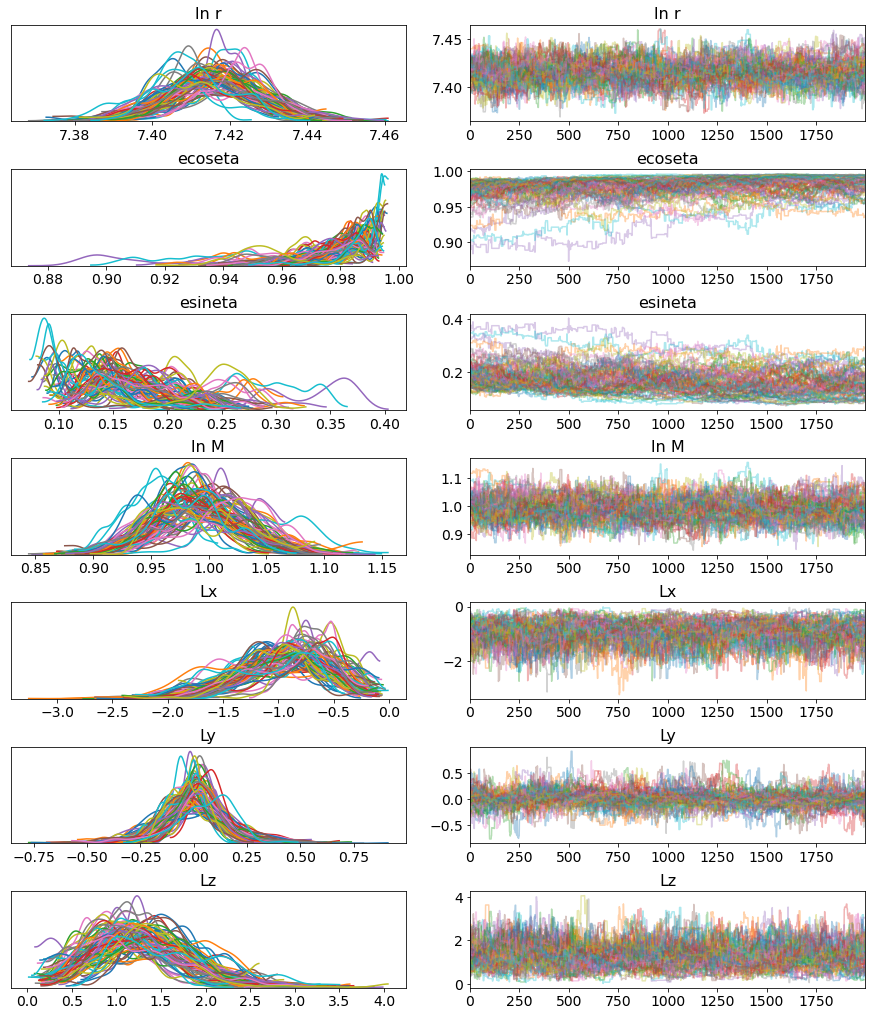

In [13]:
az.plot_trace(tulips)
  #            var_names=[{"var_0":"ln r", "var_1":'ecoseta', 'var_2':'esineta'}])#, 'ln M', 'Lx', 'Ly', 'Lz'])

array([[<AxesSubplot:ylabel='ecoseta'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='esineta'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='ln M'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='Lx'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='Ly'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='ln r', ylabel='Lz'>,
        <AxesSubplot:xlabel='ecoseta'>, <AxesSubplot:xlabel='esineta'>,
        <AxesSubplot:xlabel='ln M'>, <AxesSubplot:xlabel='Lx'>,
        <AxesSubplot:xlabel='Ly'>]], dtype=object)

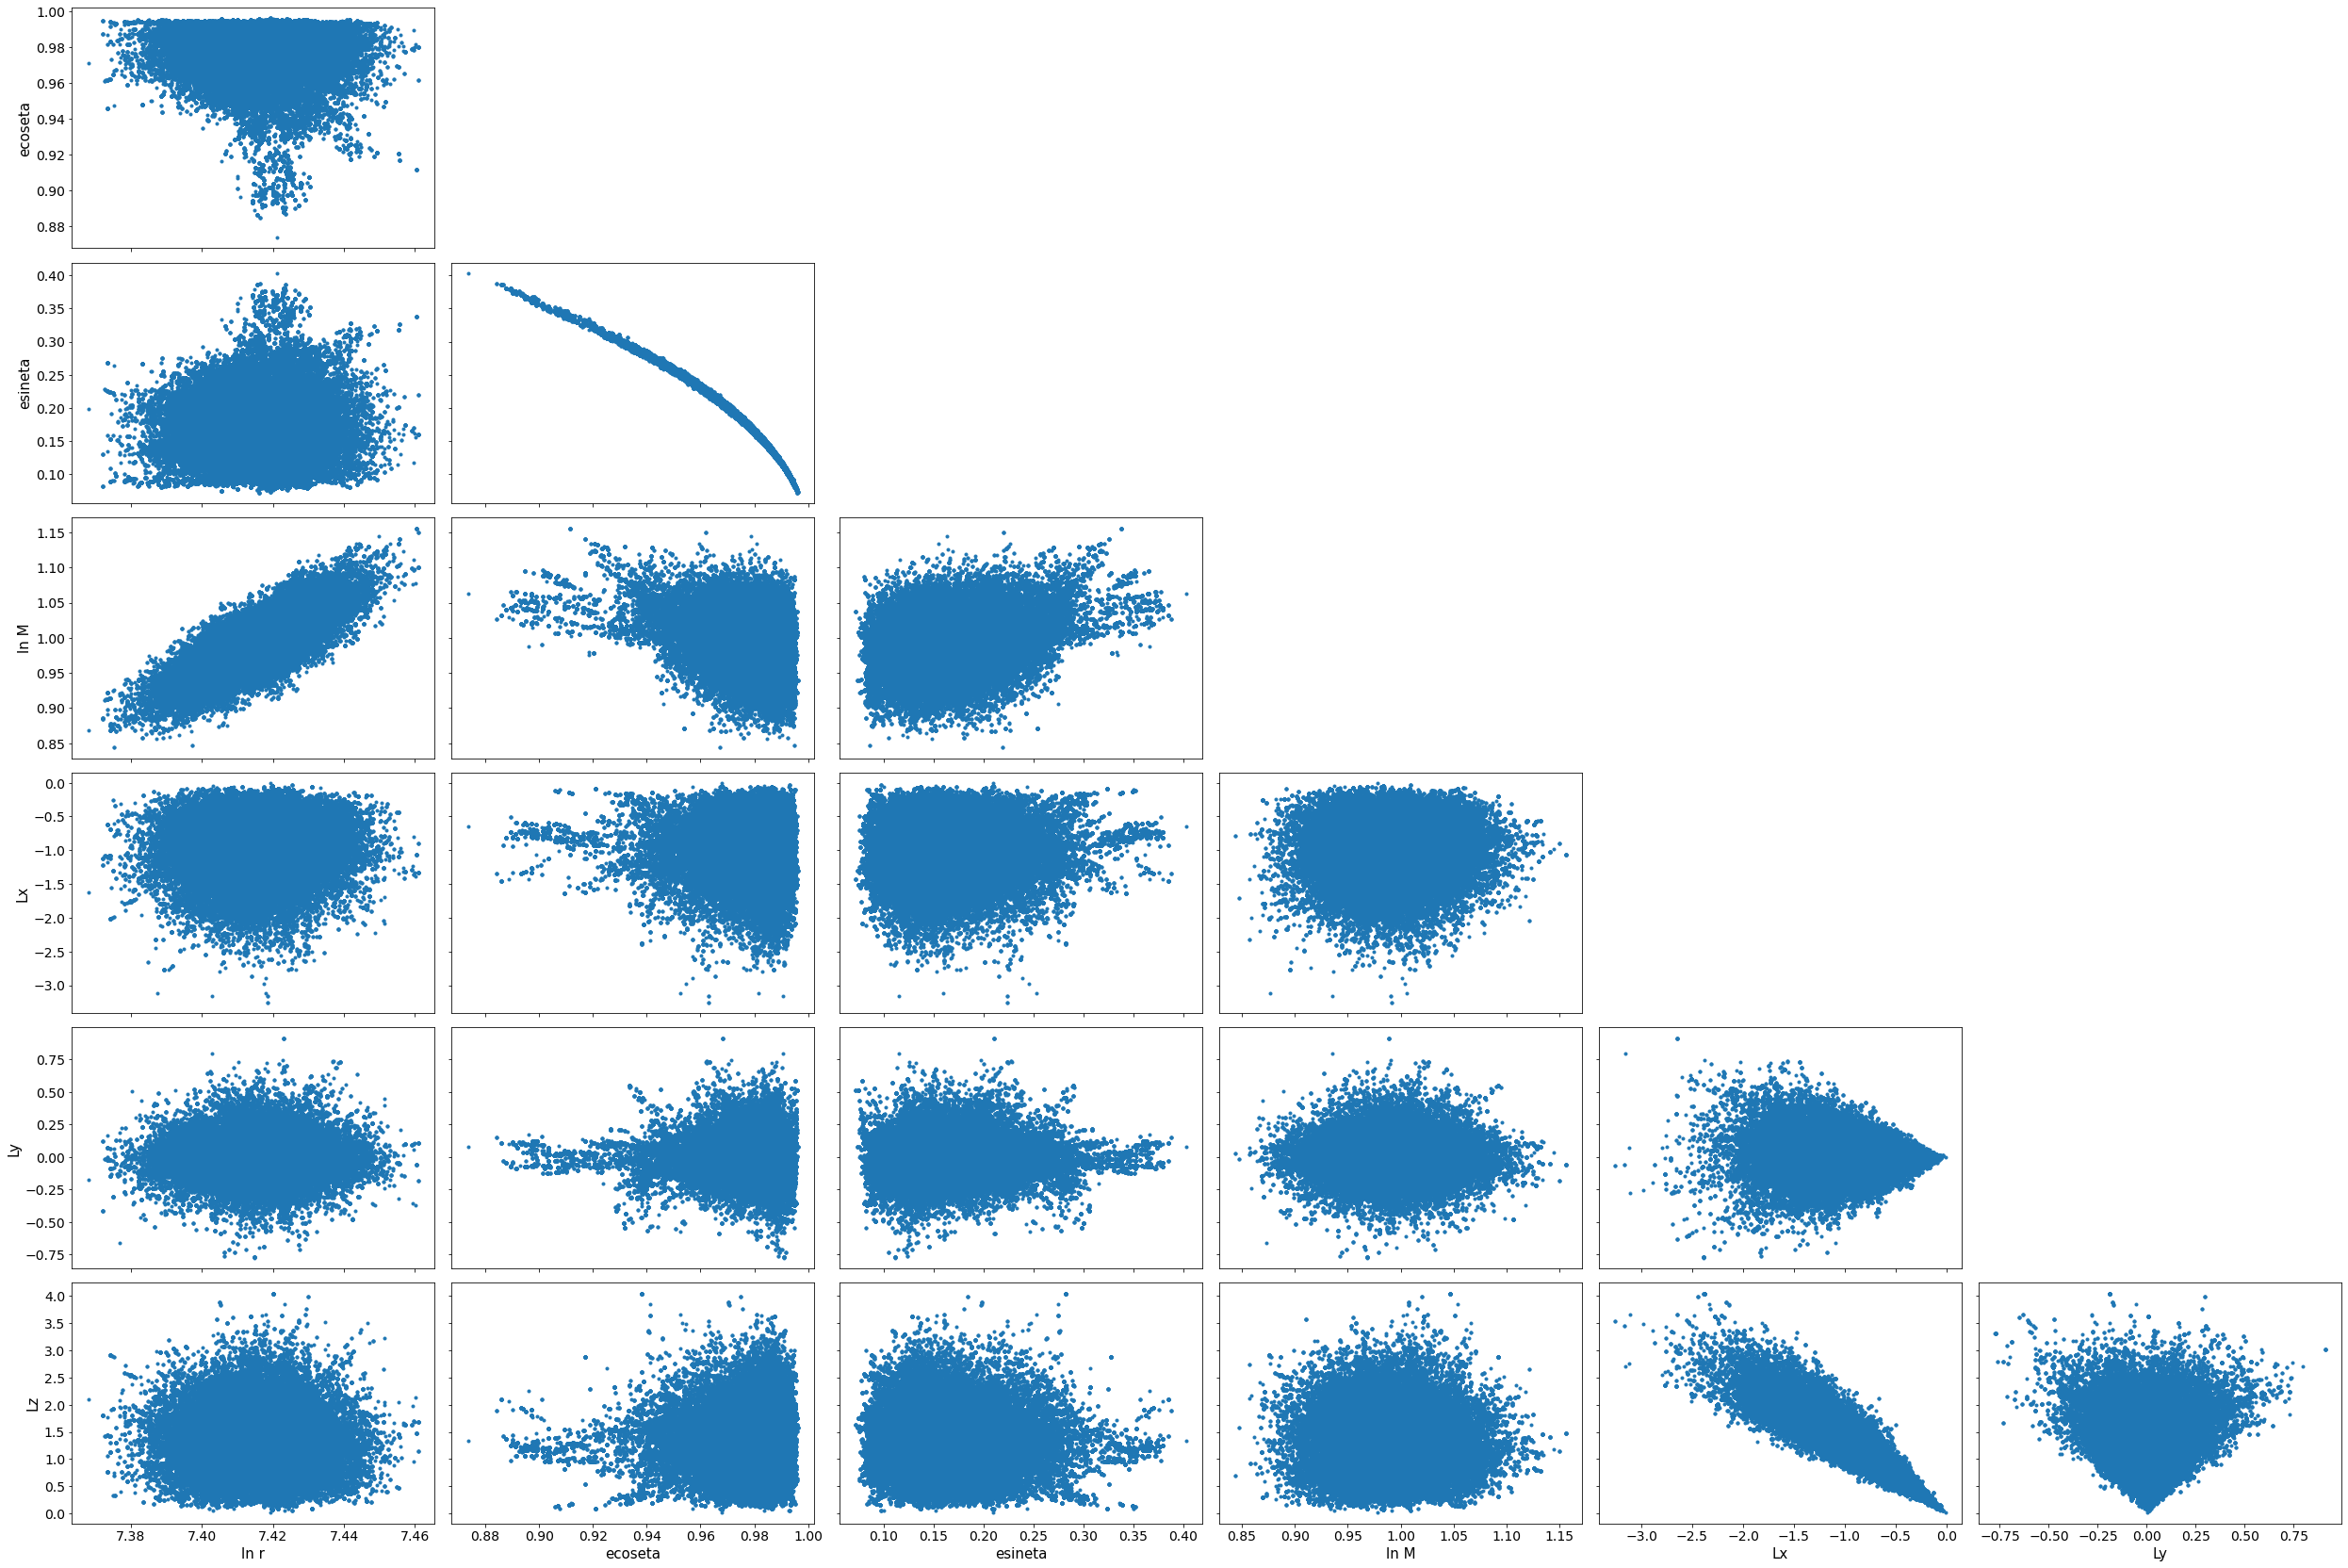

In [14]:
az.plot_pair(tulips)

In [15]:
np.mean(sampler.acceptance_fraction)

0.2889714285714285

In [16]:
np.mean(np.vstack(sampler.chain[:, ::100]), axis=0)

array([ 7.41559239e+00,  9.77039427e-01,  1.68050760e-01,  9.91088189e-01,
       -9.51206932e-01, -4.37151179e-04,  1.27175049e+00])

---

(-3.141592653589793, 3.141592653589793)

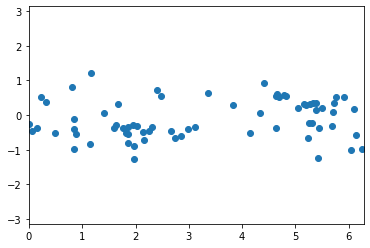

In [20]:
last_pars = model.unpack_pars(sampler.chain[:, -1].T)
last_Lhatlg = coord.CartesianRepresentation(last_pars['Lhatlg'])
last_Lhatlg_sph = last_Lhatlg.represent_as(coord.UnitSphericalRepresentation)
plt.scatter(last_Lhatlg_sph.lon, last_Lhatlg_sph.lat)
plt.xlim(0, 2*np.pi)
plt.ylim(-np.pi, np.pi)